In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from imblearn.over_sampling import RandomOverSampler

# Visualization Style
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv('/kaggle/input/isic-2019-skin-lesion-images-for-classification/ISIC_2019_Training_GroundTruth.csv')
print("Data Shape:", data.shape)

dataset_path = '/kaggle/input/isic-2019-skin-lesion-images-for-classification/'
print(os.listdir(dataset_path))


Data Shape: (25331, 10)
['MEL', 'VASC', 'SCC', 'DF', 'NV', 'ISIC_2019_Training_GroundTruth.csv', 'ISIC_2019_Training_Metadata.csv', 'BKL', 'BCC', 'AK']


In [ ]:
def load_and_resize_images(image_paths, target_size=(28, 28)):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=target_size)  
        img_array = img_to_array(img)  
        images.append(img_array)
    return np.array(images)


## 3.2 Load Images by Class
Purpose: Load all images and assign corresponding labels.

In [4]:
# Define classes
class_folders = ['MEL', 'VASC', 'SCC', 'DF', 'NV', 'BKL', 'BCC', 'AK']

# Load images and labels
all_images, all_labels = [], []

for class_name in class_folders:
    class_folder_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_folder_path)
    class_images = load_and_resize_images([os.path.join(class_folder_path, img) for img in image_files])
    all_images.append(class_images)
    all_labels.append([class_name] * len(image_files))

# Combine all data
X_all = np.concatenate(all_images, axis=0)
y_all = np.concatenate(all_labels, axis=0)

print("Shape of all images:", X_all.shape)
print("Shape of all labels:", y_all.shape)


Shape of all images: (25331, 28, 28, 3)
Shape of all labels: (25331,)


In [5]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_all)
y_one_hot = to_categorical(y_encoded)

# Reshape data for oversampling
X_reshaped = X_all.reshape(X_all.shape[0], -1)
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_reshaped, y_one_hot)

print("Class distribution after oversampling:", Counter(np.argmax(y_resampled, axis=1)))


Class distribution after oversampling: Counter({4: 12875, 7: 12875, 6: 12875, 3: 12875, 5: 12875, 2: 12875, 1: 12875, 0: 12875})


In [6]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
print(f"Shapes - X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")


Shapes - X_train: (82400, 2352), X_test: (20600, 2352), y_train: (82400, 8), y_test: (20600, 8)


In [7]:
# Reshape to (28, 28, 3)
X_train_reshaped = X_train.reshape(X_train.shape[0], 28, 28, 3)
X_test_reshaped = X_test.reshape(X_test.shape[0], 28, 28, 3)


In [8]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.01), input_shape=(28, 28, 3)),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    MaxPooling2D(),
    BatchNormalization(),
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dense(8, activation='softmax')
])


In [ ]:
import random

def EHHO(objective_func, dim, lb, ub, N=10, max_iter=20):

    lb = np.array([lb]*dim) if np.isscalar(lb) else np.array(lb)
    ub = np.array([ub]*dim) if np.isscalar(ub) else np.array(ub)

    # Initialize hawk population
    X = lb + np.random.rand(N, dim) * (ub - lb)
    fitness = np.array([objective_func(ind) for ind in X])
    best_idx = np.argmin(fitness)
    best_X, best_fit = X[best_idx].copy(), fitness[best_idx]

    #EHHO loop
    for t in range(max_iter):
        E0 = 2 * random.random() - 1  
        for i in range(N):
            E = 2 * E0 * (1 - t / max_iter)
            q = random.random()
            rand_Hawk = X[np.random.randint(N)]
            if abs(E) >= 1:
                X_new = rand_Hawk - random.random() * abs(rand_Hawk - 2 * random.random() * X[i])
            else:
                r = random.random()
                if r >= 0.5:
                    X_new = best_X - E * abs(best_X - X[i])
                else:
                    X_new = best_X - E * abs(best_X - X.mean(axis=0))

            X_new = np.clip(X_new, lb, ub)
            f_new = objective_func(X_new)

            if f_new < fitness[i]:
                fitness[i] = f_new
                X[i] = X_new

            if f_new < best_fit:
                best_X, best_fit = X_new.copy(), f_new

        print(f"Iteration {t+1}/{max_iter} | Best Fitness: {best_fit:.5f}")

    return best_X, best_fit


def cnn_objective(params):
    lr, dropout = params
    temp_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 3)),
        MaxPooling2D(),
        Flatten(),
        Dropout(dropout),
        Dense(8, activation='softmax')
    ])
    temp_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                       loss='categorical_crossentropy', metrics=['accuracy'])
    hist = temp_model.fit(X_train_reshaped[:500], y_train[:500],
                          validation_split=0.2, epochs=3, verbose=0)
    return np.min(hist.history['val_loss'])


best_params, best_score = EHHO(cnn_objective, dim=2, lb=[1e-4, 0.2], ub=[1e-2, 0.6], N=8, max_iter=10)
best_lr, best_dropout = best_params

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=best_lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 

In [10]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test), epochs=100, batch_size=64, callbacks=callbacks)


Epoch 1/100
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 87s 64ms/step - accuracy: 0.4057 - loss: 7.7963 - val_accuracy: 0.5149 - val_loss: 2.1010 - learning_rate: 0.0010
Epoch 2/100
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 80s 62ms/step - accuracy: 0.5815 - loss: 1.9342 - val_accuracy: 0.4720 - val_loss: 2.2721 - learning_rate: 0.0010
Epoch 3/100
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 81s 63ms/step - accuracy: 0.6227 - loss: 1.7967 - val_accuracy: 0.5650 - val_loss: 1.9614 - learning_rate: 0.0010
Epoch 4/100
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 81s 63ms/step - accuracy: 0.6446 - loss: 1.7336 - val_accuracy: 0.5395 - val_loss: 1.9676 - learning_rate: 0.0010
Epoch 5/100
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 83s 64ms/step - accuracy: 0.6599 - loss: 1.6737 - val_accuracy: 0.4873 - val_loss: 2.2388 - learning_rate: 0.0010
Epoch 6/100
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 81s 63ms/step - accuracy: 0.6767 - loss: 1.6068 - val_accuracy: 0.6829 - val_loss: 1.5507 - learning_rate: 0.0010
Epoch 7/100
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 81s 63ms/step -

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')
    epochs = [i + 1 for i in range(len(tr_acc))]
    loss_label = f'Best Epoch = {index_loss + 1}'
    acc_label = f'Best Epoch = {index_acc + 1}'

    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'g', label='Validation Loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


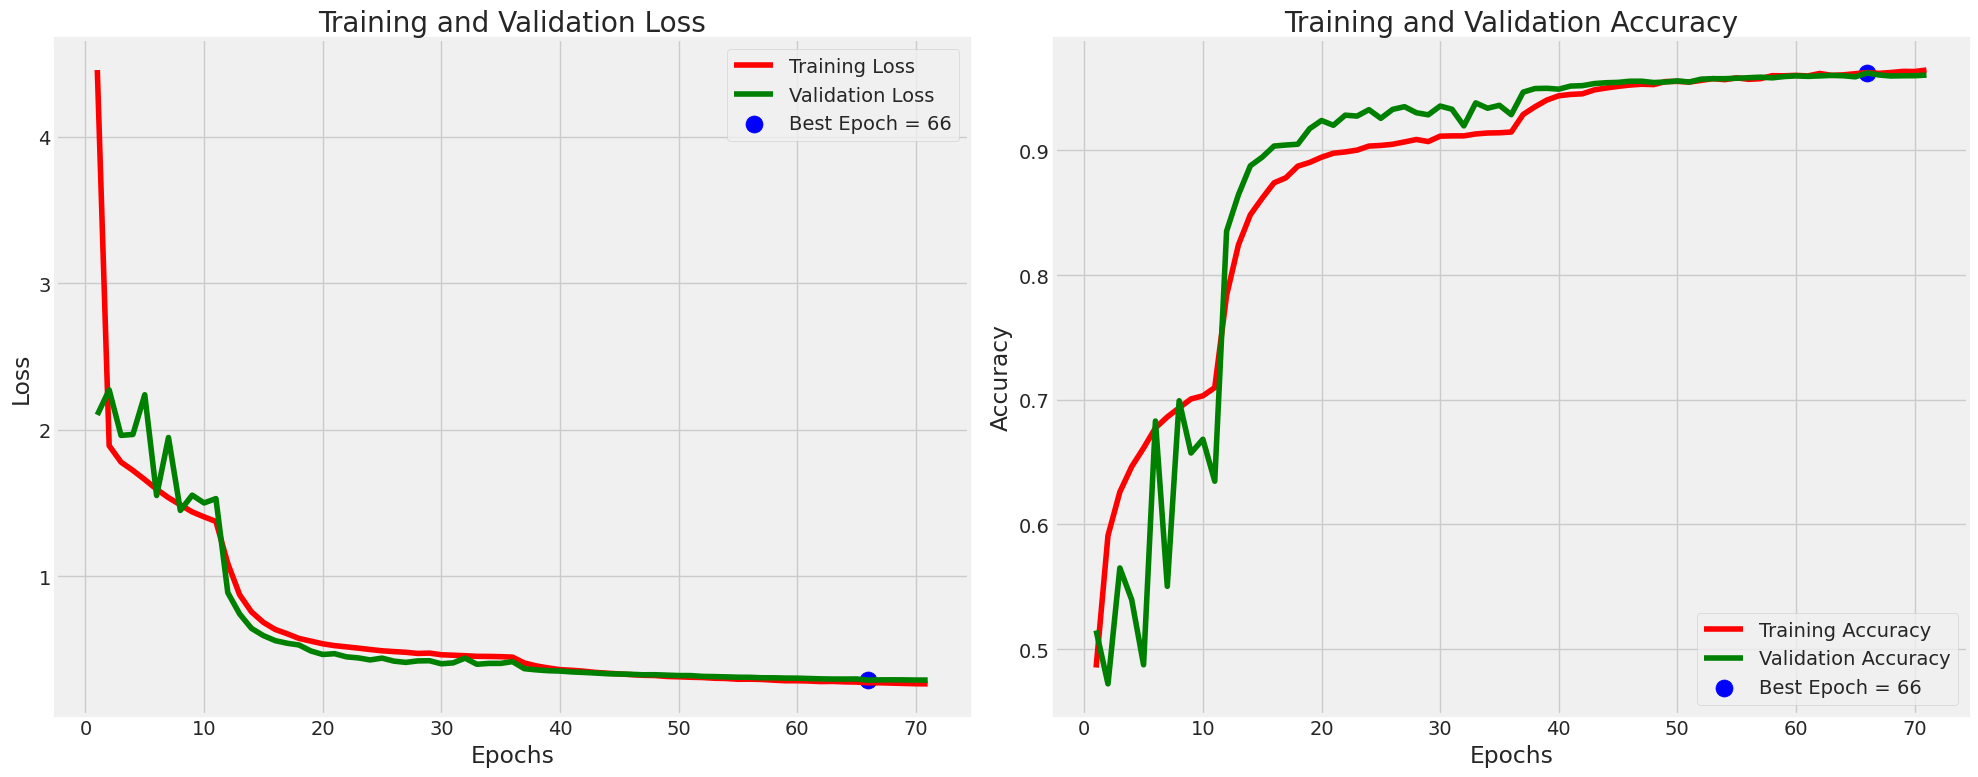

In [12]:
plot_training(history)

In [13]:
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


644/644 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9621 - loss: 0.2908
Test Accuracy: 96.20%
Test Loss: 0.2901


644/644 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step
              precision    recall  f1-score   support

          AK       0.99      1.00      1.00      2582
         BCC       0.94      0.99      0.96      2665
         BKL       0.95      0.98      0.97      2582
          DF       1.00      1.00      1.00      2517
         MEL       0.91      0.90      0.91      2612
          NV       0.91      0.82      0.87      2557
         SCC       0.99      1.00      1.00      2550
        VASC       1.00      1.00      1.00      2535

    accuracy                           0.96     20600
   macro avg       0.96      0.96      0.96     20600
weighted avg       0.96      0.96      0.96     20600



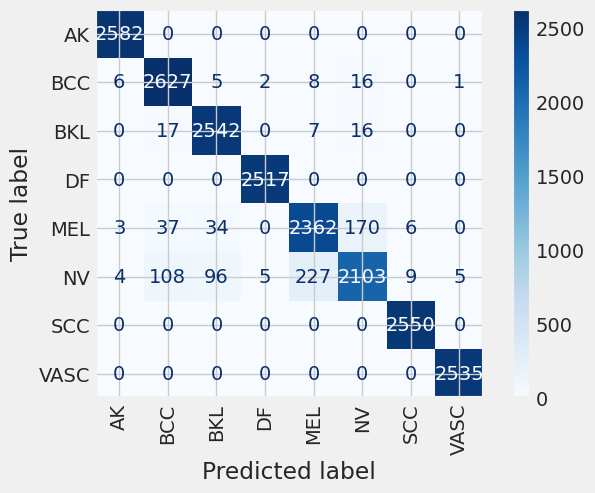

In [14]:
y_pred = np.argmax(model.predict(X_test_reshaped), axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.show()


In [ ]:
model.save("model.h5")

In [ ]:
#https://www.kaggle.com/datasets/salviohexia/isic-2019-skin-lesion-images-for-classification/data